# Adversarial attacks on 1D double well potential

In this notebook, we reproduce the example of adversarial attacks on the asymetric 1D double well shown in the supporting information of [our paper](https://arxiv.org/abs/2101.11588).

The notebook uses the models and the helper functions in the `robust` folder of this repo.

In [1]:
import sys
sys.path.append('..')

import robust as rb
import torch as ch
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

## Creating the 1D double well

Using the potentials available at the `robust` module, we created an asymetric 1D double well with the desired zeros, depth and offset. In particular, the equation for the potential is the following:

$$E(x) = 5 x^4 - 10 x^2 + 1.5 x$$

Then, the `potential` object creates the training set, the `true_potential` is used for the evaluation (e.g. the surrogate model, or analogous to a FF or DFT calculation). We also select the plotting range for the potentials, in order to achieve a better visualization for this work.

In [2]:
WELL_ZEROS = 1
WELL_DEPTH = 5
WELL_OFFSET = 3

ENERGY_THRESHOLD = -5.5

potential = rb.potentials.MaskedDoubleWell.from_zeros_and_depth(
    zeros=WELL_ZEROS,
    depth=WELL_DEPTH,
    offset=WELL_OFFSET,
    emax=ENERGY_THRESHOLD,
    energy_noise=0.0,
)

true_potential = rb.potentials.DoubleWell.from_zeros_and_depth(
    zeros=WELL_ZEROS,
    depth=WELL_DEPTH,
    offset=WELL_OFFSET,
)

In [3]:
PLOT_RANGE = 1.65

x = ch.linspace(-PLOT_RANGE * WELL_ZEROS, PLOT_RANGE * WELL_ZEROS, steps=500)

dset = rb.PotentialDataset(*potential(x))

../robust/data.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return ch.tensor(tensor).reshape(len(tensor), -1)
../robust/data.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return ch.tensor(tensor)


In [4]:
xplot = ch.linspace(-PLOT_RANGE * WELL_ZEROS, PLOT_RANGE * WELL_ZEROS, steps=250)
xplot, eplot, fplot = potential(xplot, clip=False, add_noise=False)
dplot = rb.PotentialDataset(xplot, eplot, fplot)

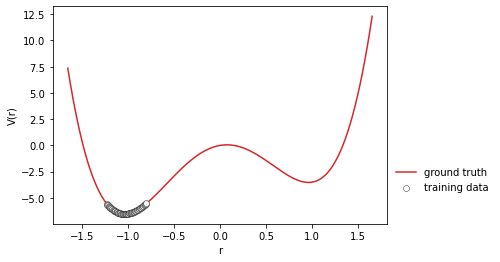

In [5]:
fig, ax = plt.subplots()

ax.plot(dplot.x, dplot.e, c='#d62728', label='ground truth', zorder=-1)
ax.scatter(dset.x, dset.e, alpha=0.8, c='w', edgecolor='k', linewidths=0.5, label='training data')

ax.set_xlabel('r')
ax.set_ylabel('V(r)')

ax.legend(frameon=False, bbox_to_anchor=(1.0, 0.3))
plt.show()

## Training the models

Now, we select all hyperparameters of the models. The NN ensemble is generated from the `model_params`. The `loss_params` are used both for the training and adversarial loss, although the latter uses only the temperature. `score_params` uses some deduplication strategies, as explained in Sec. II-C of the paper. Afterwards, the initial pipeline (i.e. one loop cycle) is created, and the model is trained.

In [6]:
loss_params = {
    'energy_coef': 1,
    'forces_coef': 10,
    'temperature': 5,
}

model_params = {
    'input_dim': 1,
    'num_layers': 4,
    'layer_dim': 1024,
    'num_networks': 5
}

optim_params = {
    'lr': 1e-3,
}

train_params = {
    'max_epochs': 500,
    'batch_size': 35,
}

attack_params = {
    'delta_std': 1e-2,
    'optim_kws': optim_params,
}

score_params = {
    'UncertaintyPercentile': {'percentile': 80},
    'RmsdScore': {'threshold': 0.05},
    'ClusterScore': {'threshold': 0.01},
}

prefix = 'models_1D'

In [7]:
pipeline = rb.ForwardPipeline(
    dset,
    model_params,
    loss_params,
    optim_params,
    train_params,
    attack_params,
    name=f"{prefix}/gen_1",
)

# If you don't have a GPU, set DEVICE to 'cpu'
DEVICE = 0

../robust/data.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return ch.tensor(tensor).reshape(len(tensor), -1)
../robust/data.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return ch.tensor(tensor)


In [8]:
loop = rb.actlearn.ActiveLearning(
    pipeline,
    true_potential,
    device=DEVICE,
    train_epochs=400,
    attack_epochs=400,
    scores=score_params,
    num_generations=5,
    name_prefix=prefix,
)

In [9]:
loop.loop()

ACT_LEARN: GEN 1: training model
 Time | Epoch | Learning rate | Train loss | Validation loss | MAE Energy | MAE Forces | GPU Memory (MB)
09:28 |    25 |     1.000e-03 |   295.2845 |        376.7279 |     2.8200 |    27.5332 |             110
09:30 |    50 |     1.000e-03 |   284.9616 |        382.2017 |     1.7008 |    27.4558 |             110
09:31 |    75 |     1.000e-03 |   283.4744 |        364.4057 |     1.4696 |    27.0801 |             110
09:32 |   100 |     1.000e-03 |   181.2429 |        177.2878 |     2.5489 |    18.1723 |             110
09:34 |   125 |     1.000e-03 |    15.6866 |         24.0649 |     0.9494 |     5.8052 |             110
09:36 |   150 |     1.000e-03 |    10.3059 |         11.0350 |     0.5938 |     4.2531 |             110
09:37 |   175 |     1.000e-03 |     6.0369 |          9.6108 |     0.7520 |     3.5627 |             110
09:39 |   200 |     1.000e-03 |     4.4400 |          9.7781 |     0.3036 |     3.7872 |             110
09:41 |   225 |     1.

13:13 |   125 |     1.000e-03 |     2.9218 |          0.0893 |     0.3497 |     0.3443 |             616
13:15 |   150 |     1.000e-03 |    21.2032 |          0.9422 |     0.1619 |     1.0922 |             616
13:17 |   175 |     1.000e-03 |    11.7749 |          1.1008 |     0.3576 |     1.3047 |             616
13:18 |   200 |     1.000e-03 |     2.8552 |          1.0912 |     0.3611 |     1.1982 |             616
13:19 |   225 |     5.000e-04 |     1.0071 |          0.2924 |     0.1077 |     0.6020 |             616
13:22 |   250 |     5.000e-04 |     0.2478 |          0.0316 |     0.0766 |     0.2118 |             616
13:25 |   275 |     5.000e-04 |     0.2635 |          0.0145 |     0.1489 |     0.1568 |             616
13:28 |   300 |     5.000e-04 |     0.0704 |          0.0091 |     0.1757 |     0.1209 |             616
13:30 |   325 |     5.000e-04 |     0.0915 |          0.0103 |     0.1728 |     0.1225 |             616
13:32 |   350 |     5.000e-04 |     0.2365 |          0

## Plotting the evolution of the active learning loop

This plot reproduces Fig. S3 of the paper. It essentially shows all adversarial attacks and the evolution of the uncertainty/loss across generations.

../robust/data.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return ch.tensor(tensor).reshape(len(tensor), -1)
../robust/data.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return ch.tensor(tensor)
../robust/data.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return ch.tensor(tensor).reshape(len(tensor), -1)
../robust/data.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor

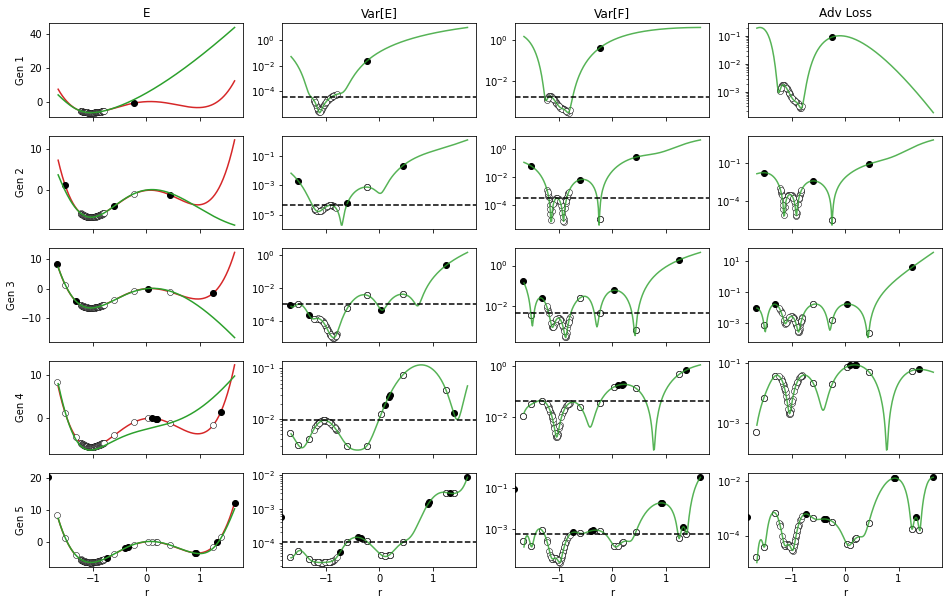

In [10]:
N_GENS = len(loop.generations)
N_PLOTS = 4
PERCENTILE = 80

fig, ax_fig = plt.subplots(N_GENS, N_PLOTS, figsize=(N_PLOTS * 4, N_GENS * 2), sharex=True)

for gen, ax_row in zip(loop.generations, ax_fig):
    pipeline = gen['pipeline']
    attacks = gen['attacks']
    attacks_truth = rb.PotentialDataset(*true_potential(attacks.x))

    train_model, _, _ = pipeline.evaluate(pipeline.train_loader, DEVICE)
    dplot_model, _, _ = pipeline.evaluate(dplot.get_loader(train_params['batch_size']), DEVICE)
    
    ax = ax_row[0]
    ax.plot(dplot.x, dplot.e, c='#d62728', label='ground truth', zorder=-1)
    ax.plot(dplot_model.x, dplot_model.e.mean(-1), c='#2ca02c', label='prediction')
    ax.scatter(
        pipeline.dset.x,
        pipeline.dset.e,
        c='w',
        linewidths=0.5,
        edgecolor='k',
        label='training data',
    )
    
    ax.scatter(
        pipeline.dset_train.x,
        pipeline.dset_train.e,
        c='w',
        linewidths=0.5,
        edgecolor='k',
        label='training data',
    )

    if len(attacks) > 0:
        ax.scatter(
            attacks_truth.x,
            attacks_truth.e,
            c='k',
            label='attacks',
        )

    ax = ax_row[1]
    ax.semilogy(dplot_model.x, dplot_model.e.var(-1), alpha=0.8, c='#2ca02c', label='prediction')
    ax.scatter(
        train_model.x,
        train_model.e.var(-1),
        c='w',
        linewidths=0.5,
        edgecolor='k',
        label='training data'
    )
        
    if len(attacks) > 0:
        ax.scatter(
            attacks.x,
            attacks.e.var(-1),
            c='k',
            label='attacks',
        )

    threshold = stats.scoreatpercentile(train_model.e.var(-1), PERCENTILE)

    xlim = ax.get_xlim()
    ax.plot(xlim, [threshold] * 2, 'k--', label=f'{PERCENTILE}th percentile')
    ax.set_xlim(xlim)

    ax = ax_row[2]
    ax.semilogy(dplot_model.x, dplot_model.f.var(-1), alpha=0.8, c='#2ca02c', label='prediction')
    ax.scatter(
        train_model.x,
        train_model.f.var(-1),
        c='w',
        linewidths=0.5,
        edgecolor='k',
        label='training data',
        zorder=2,
    )
    
    if len(attacks) > 0:
        ax.scatter(
            attacks.x,
            attacks.f.var(-1),
            c='k',
            label='attacks',
            zorder=2,
        )

    threshold = stats.scoreatpercentile(train_model.f.var(-1), PERCENTILE)
    if gen['generation'] == 1:
        first_gen_fthreshold = threshold
    
    xlim = ax.get_xlim()
    ax.plot(xlim, [threshold] * 2, 'k--', label=f'{PERCENTILE}th percentile')
    ax.set_xlim(xlim)

    ax = ax_row[3]
    adv_loss = pipeline.get_adv_loss()
    
    ax.semilogy(
        dplot_model.x,
        -adv_loss.loss_fn(dplot_model.x, dplot_model.e, dplot_model.f),
        alpha=0.8,
        c='#2ca02c',
        label='prediction'
    )
    ax.scatter(
        train_model.x,
        -adv_loss.loss_fn(train_model.x, train_model.e, train_model.f),
        c='w',
        linewidths=0.5,
        edgecolor='k',
        label='training data'
    )
    
    if len(attacks) > 0:
        ax.scatter(
            attacks.x,
            -adv_loss.loss_fn(attacks.x, attacks.e, attacks.f),
            c='k',
            label='attacks',
        )

ax_fig[0, 0].set_title('E')
ax_fig[0, 1].set_title('Var[E]')
ax_fig[0, 2].set_title('Var[F]')
ax_fig[0, 3].set_title('Adv Loss')

for i, ax in enumerate(ax_fig[:, 0], 1):
    ax.set_ylabel(f'Gen {i}')

for ax in ax_fig[-1, :]:
    ax.set_xlabel('r')

plt.show()